In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def sine_wave(num_samples , t ):
    x = np.zeros(shape = [num_samples , t])
    y = np.zeros(shape = [num_samples , t])
    for i in range(num_samples) : 
        seq = np.sin(np.linspace(2*i*np.pi  , 2*(i+1)*np.pi , t+1) )
        x[i][:] = seq[:-1]
        y[i][:] = seq[1:]
    return x , y    

In [23]:
class SineWaveDataset(Dataset):
    def __init__(self, num_samples, t):
        self.x, self.y = sine_wave(num_samples, t)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
num_samples = 500
t = 50
batch_size = 32

dataset = SineWaveDataset(num_samples, t)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [24]:
class Rnn(nn.Module) :
    def __init__(self,input_size , hidden_size ,output_size):
        super().__init__() 
        self.input_size = input_size;
        self.hidden_size = hidden_size;
        self.output_size = output_size;
        self.W_ax = nn.Parameter(torch.Tensor(input_size,hidden_size));
        self.W_aa = nn.Parameter(torch.Tensor(hidden_size,hidden_size));
        self.W_ya = nn.Parameter(torch.Tensor(hidden_size,output_size));
        self.b_a  = nn.Parameter(torch.zeros(hidden_size))
        self.b_y  = nn.Parameter(torch.zeros(output_size))
        nn.init.xavier_uniform_(self.W_ax)
        nn.init.xavier_uniform_(self.W_aa)
        nn.init.xavier_uniform_(self.W_ya)
    def forward(self ,X,hidden_state  = None):
        batch_size , len_seq ,_ = X.size()
        if (hidden_state == None) :
            hidden_state = torch.zeros(X.size()[0], self.hidden_size)
        outputs = torch.zeros(batch_size, len_seq, self.output_size)
        for t in range(len_seq):
            x_t = X[:, t , :]
            x_a = torch.matmul(x_t, self.W_ax) 
    
            a_a = torch.matmul(hidden_state, self.W_aa) 
            hidden_state = torch.tanh(x_a + a_a + self.b_a)
            y_t = torch.matmul(hidden_state, self.W_ya) + self.b_y
            outputs[:, t, :] = y_t
        # print(outputs.shape)
        return outputs , hidden_state
    

In [25]:
batch_size = 32
hidden_size = 32
model = Rnn(1,32,1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [34]:
from tqdm import tqdm
t = 50
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        x_batch = x_batch.unsqueeze(dim=-1) 
        hidden_state = torch.zeros(x_batch.size()[0], hidden_size)
        y_pred, _ = model(x_batch, hidden_state)
        y_pred = y_pred.squeeze(-1)
        loss = loss_fn(y_pred, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 2 == 0:
            print(f"Step[{i+1}/{len(dataloader)}].:  Loss: {loss.item():.4f}")
    
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {running_loss / len(dataloader):.4f}")


Epoch 1/3: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 89.19it/s]


Step[2/16].:  Loss: 0.0053
Step[4/16].:  Loss: 0.0049
Step[6/16].:  Loss: 0.0045
Step[8/16].:  Loss: 0.0041
Step[10/16].:  Loss: 0.0039
Step[12/16].:  Loss: 0.0037
Step[14/16].:  Loss: 0.0035
Step[16/16].:  Loss: 0.0033
Epoch 1/3 - Average Loss: 0.0042


Epoch 2/3:   0%|                                                                                | 0/16 [00:00<?, ?it/s]

Step[2/16].:  Loss: 0.0030


Epoch 2/3: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 83.31it/s]


Step[4/16].:  Loss: 0.0029
Step[6/16].:  Loss: 0.0027
Step[8/16].:  Loss: 0.0025
Step[10/16].:  Loss: 0.0024
Step[12/16].:  Loss: 0.0022
Step[14/16].:  Loss: 0.0021
Step[16/16].:  Loss: 0.0020
Epoch 2/3 - Average Loss: 0.0025


Epoch 3/3:   0%|                                                                                | 0/16 [00:00<?, ?it/s]

Step[2/16].:  Loss: 0.0019
Step[4/16].:  Loss: 0.0017


Epoch 3/3: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 89.66it/s]

Step[6/16].:  Loss: 0.0017
Step[8/16].:  Loss: 0.0016
Step[10/16].:  Loss: 0.0015
Step[12/16].:  Loss: 0.0014
Step[14/16].:  Loss: 0.0013
Step[16/16].:  Loss: 0.0013
Epoch 3/3 - Average Loss: 0.0016


In [35]:
x,y = dataset[0]
x,y

(tensor([ 0.0000e+00,  1.2533e-01,  2.4869e-01,  3.6812e-01,  4.8175e-01,
          5.8779e-01,  6.8455e-01,  7.7051e-01,  8.4433e-01,  9.0483e-01,
          9.5106e-01,  9.8229e-01,  9.9803e-01,  9.9803e-01,  9.8229e-01,
          9.5106e-01,  9.0483e-01,  8.4433e-01,  7.7051e-01,  6.8455e-01,
          5.8779e-01,  4.8175e-01,  3.6812e-01,  2.4869e-01,  1.2533e-01,
         -3.2162e-16, -1.2533e-01, -2.4869e-01, -3.6812e-01, -4.8175e-01,
         -5.8779e-01, -6.8455e-01, -7.7051e-01, -8.4433e-01, -9.0483e-01,
         -9.5106e-01, -9.8229e-01, -9.9803e-01, -9.9803e-01, -9.8229e-01,
         -9.5106e-01, -9.0483e-01, -8.4433e-01, -7.7051e-01, -6.8455e-01,
         -5.8779e-01, -4.8175e-01, -3.6812e-01, -2.4869e-01, -1.2533e-01]),
 tensor([ 1.2533e-01,  2.4869e-01,  3.6812e-01,  4.8175e-01,  5.8779e-01,
          6.8455e-01,  7.7051e-01,  8.4433e-01,  9.0483e-01,  9.5106e-01,
          9.8229e-01,  9.9803e-01,  9.9803e-01,  9.8229e-01,  9.5106e-01,
          9.0483e-01,  8.4433e-01,  

In [36]:

x,y = dataset[0]
x,y
model.eval()
with torch.no_grad():
    x = x.unsqueeze(0).unsqueeze(-1)  
    print(x.shape)  
    # hidden_state = torch.zeros(x.size(0), 32)  
    y_pred, _ = model(x)
    y_pred = y_pred.squeeze(-1)
print("Predicted output:", y_pred)

torch.Size([1, 50, 1])
Predicted output: tensor([[ 0.1066,  0.1905,  0.2946,  0.4159,  0.5613,  0.6773,  0.7779,  0.8491,
          0.8964,  0.9336,  0.9505,  0.9605,  0.9536,  0.9460,  0.9181,  0.8882,
          0.8386,  0.7874,  0.7143,  0.6372,  0.5373,  0.4336,  0.3075,  0.1796,
          0.0333, -0.1078, -0.2589, -0.3949, -0.5300, -0.6403, -0.7412, -0.8142,
         -0.8769, -0.9167, -0.9499, -0.9659, -0.9753, -0.9694, -0.9547, -0.9261,
         -0.8871, -0.8350, -0.7707, -0.6929, -0.6007, -0.4943, -0.3725, -0.2376,
         -0.0893,  0.0664]])


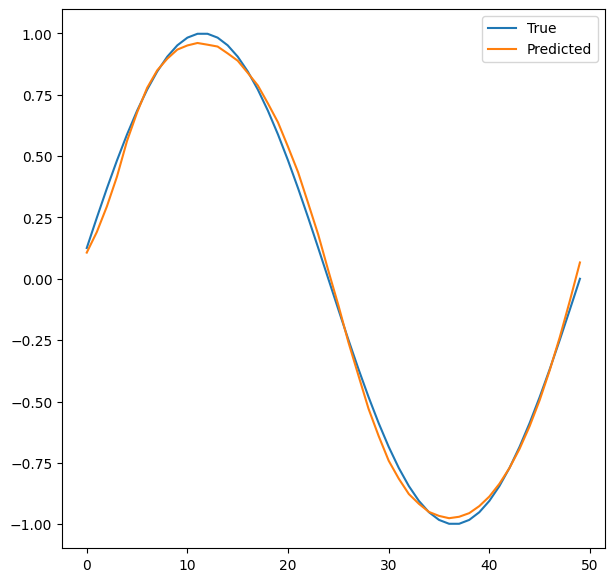

In [37]:
plt.figure(figsize=(7,7))
plt.plot(y, label='True')
plt.plot(y_pred[0], label='Predicted')
plt.legend()
plt.show()
